# Load libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import math

# SKLearn
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

# Scipy
from scipy.stats import skew

# Graphics
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)

# Load data

In [2]:
DF_trn = pd.read_csv("Data/train.csv")
DF_tst = pd.read_csv("Data/test.csv")

# General notebook
from IPython.display import display

# Combine test and training data, for the purpose of manipulating features in both simultaneously
DF = pd.concat([DF_trn, DF_tst], axis=0, ignore_index=True)

# Get length of training and test test, and create variables to index each subset
n_trn = len(DF_trn)
n_tst = len(DF_tst)
n_ttl = n_trn+n_tst
trn = np.arange(n_trn)
tst = np.arange(n_trn, n_ttl)

# Discard sale Id (this is just index +1)
del DF["Id"]
DF.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


# First look
Plot distribution of prices

Range for year of sale: 2006 - 2010
Range for sale prices: 34900.0 - 755000.0


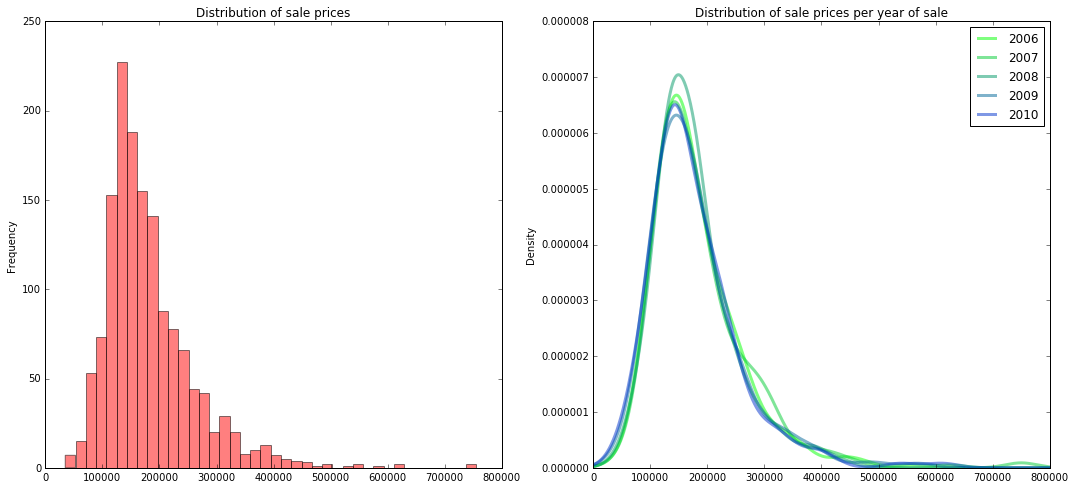

In [3]:
year_range = [DF.loc[trn,'YrSold'].min(), DF.loc[trn,'YrSold'].max()] 
print("Range for year of sale: " + str(year_range[0]) + " - " + str(year_range[1]))
print("Range for sale prices: " + str(DF.loc[trn,'SalePrice'].min()) + " - " + str(DF.loc[trn,'SalePrice'].max()))


fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot2grid((1,2),(0,0))

DF.loc[trn,'SalePrice'].plot(kind='hist', color='red', label='Sale Price', bins=40, alpha=0.5)    
plt.title("Distribution of sale prices")

ax2 = plt.subplot2grid((1,2),(0,1))

SalePrices_year = [[] for x in range(year_range[0],year_range[1]+1)]
for year in range(year_range[0],year_range[1]+1):
    idx = np.array(DF.loc[trn,'YrSold']==year)
    SalePrices_year[year-year_range[0]] = DF.loc[idx,'SalePrice']
    SalePrices_year[year-year_range[0]].plot(kind='kde', color=[0,1-(year-2006)/5,(year-2006)/5], label=year, alpha=0.5, lw=3)

plt.title("Distribution of sale prices per year of sale")
plt.xlim(0,800000)
plt.legend()

The shape of the distribution looks quite consistent over the years. Despite the data spanning the 2008 financial crisis, the year of sale does not seem to be a particularly powerful predictor of sale price on its own. 
Next, a look at the relation between year built and 

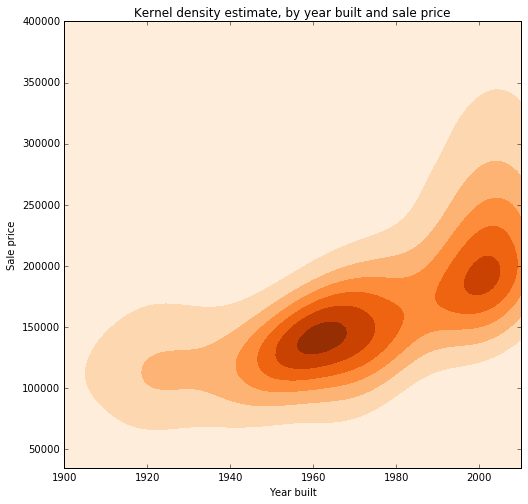

In [4]:
x = DF.loc[trn,'YearBuilt']
y = DF.loc[trn,'SalePrice']
xmin, xmax = 1900, DF.loc[trn,'YearBuilt'].max()
ymin, ymax = DF.loc[trn,'SalePrice'].min(), 400000

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(18,8))
ax1 = plt.subplot2grid((1,2),(0,0))

ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Oranges')
# Label plot
plt.title('Kernel density estimate, by year built and sale price')
ax.set_xlabel('Year built')
ax.set_ylabel('Sale price')


# Dimensionality reduction/Imputation/preprocessing
## Basement


In [5]:
bsmt_cols = [col for col in DF.columns if "Bsmt" in col]
DF[bsmt_cols].head()

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
0,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,856.0
1,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,1262.0
2,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,920.0
3,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,756.0
4,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,1145.0


In [6]:
# Assume that basement areas for which no finish is specified are unfinished
DF.loc[DF.loc[:,"BsmtFinType1"].isnull(), "BsmtFinType1" ] ="Unf"
DF.loc[DF.loc[:,"BsmtFinType2"].isnull(), "BsmtFinType2" ] ="Unf"

# Get list of the names of basement finish types, and use each to generate list of column names for new variables
bsmt_fintypes = [fin for fin in DF["BsmtFinType1"].unique() if isinstance(fin, str)]

# Initialize new dataframe to hold these variables
DF_bsmt_area = pd.DataFrame(data=np.zeros((n_ttl,len(bsmt_fintypes))), columns=bsmt_fintypes)
# Fill the nonzero entries
for i_house in range(n_ttl):
    if DF.loc[i_house, "BsmtFinSF1"]>0:
        fin_type = DF.loc[i_house, "BsmtFinType1"]
        DF_bsmt_area.loc[i_house, fin_type] = DF.loc[i_house, "BsmtFinSF1"]
    
        if DF.loc[i_house, "BsmtFinSF2"]>0:
            fin_type = DF.loc[i_house, "BsmtFinType2"]
            DF_bsmt_area.loc[i_house, fin_type] += DF.loc[i_house, "BsmtFinSF2"]

    # Add area from the separate column for unfinished basement area
    if DF.loc[i_house, "BsmtUnfSF"]>0:
        DF_bsmt_area.loc[i_house, "Unf"] += DF.loc[i_house, "BsmtUnfSF"]

# Rename the columns to work in the context of the entire dataframe
DF_bsmt_area.columns = ["BsmtSF_" + col for col in DF_bsmt_area.columns]

In [7]:
# Remove obsolete features from DF and replace with the new features
DF_no_bsmt_area = DF.drop(["BsmtFinSF1", "BsmtFinSF2", "BsmtFinType1", "BsmtFinType2", "BsmtUnfSF", "TotalBsmtSF"],
        axis=1)
# Append new features
DF = pd.concat([DF_no_bsmt_area, DF_bsmt_area], axis=1)

In [8]:
# For some bsmt features, missing values actually mean "no basement", rather than missing data. Replace these with "NoBsmt".
NoBsmt_feats = ["BsmtQual", "BsmtCond", "BsmtExposure"]
DF.loc[:,NoBsmt_feats] = DF.loc[:,NoBsmt_feats].fillna(value="None")

In [9]:
# For the houses that still have missing bsmt features values, display all bsmt features
bsmt_cols = [col for col in DF.columns if "Bsmt" in col]
houses_NA = DF.loc[:,bsmt_cols].isnull().sum(axis=1)>0
display(DF.loc[ houses_NA, bsmt_cols])
# Since these houses have no basement, they logically don't have a bathroom in the basement, so set missing values to 0.0.
DF.loc[houses_NA, ["BsmtFullBath", "BsmtHalfBath"]] = DF.loc[houses_NA, ["BsmtFullBath", "BsmtHalfBath"]].fillna(value=0.0)


,BsmtCond,BsmtExposure,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtSF_GLQ,BsmtSF_ALQ,BsmtSF_Unf,BsmtSF_Rec,BsmtSF_BLQ,BsmtSF_LwQ
2120,None,None,NaN,NaN,None,0.0,0.0,0.0,0.0,0.0,0.0
2188,None,None,NaN,NaN,None,0.0,0.0,0.0,0.0,0.0,0.0


## Neighborhood
The neighborhoods are encoded as a categorical variable. Replace this encoding with the average house price in the neighborhood the house is in. This avoids the creation of dummy variables, which would increase dimeensionality.

In [10]:
#nbhds = DF.Neighborhood.unique()
#nbhd_value_map = {x: DF.loc[DF.Neighborhood==x, "SalePrice"].mean() for x in nbhds}
#DF.Neighborhood = DF.Neighborhood.map(nbhd_value_map)

## Pool features


In [11]:
# For all houses with a pool, inspect the pool quality and area variables as well as the sale price
houses_w_pool = DF.loc[:,"PoolQC"].notnull()
display(DF.loc[houses_w_pool, ["PoolQC", "PoolArea","SalePrice"]])
# With only 7 houses with a pool in the training set, using more than one variable for the pool would be pointless, 
# but discarding it altogether would also be wasteful. Create a single variable, 'Pool', which holds the product of
# the pool area and the pool quality (encoded as Fair = 1, Good = 2, Excellent = 3). Use zero as the value for no pool.
dic = {"Fa": 1, "Gd": 2, "Ex": 3}
PoolQC = DF.loc[:,"PoolQC"].map(dic).fillna(0)
PoolArea = DF.loc[:,"PoolArea"].fillna(0)
Pool = PoolQC * PoolArea
Pool[houses_w_pool]
# Replace PoolQC and PoolArea with Pool
DF_no_pool = DF.drop(["PoolQC", "PoolArea"], axis=1)
DF = pd.concat([DF_no_pool, pd.DataFrame(data=Pool, columns=["Pool"])], axis=1)
# Sort all features
DF.sort_index(axis=1, inplace=True)

,PoolQC,PoolArea,SalePrice
197,Ex,512,235000.0
810,Fa,648,181000.0
1170,Gd,576,171000.0
1182,Ex,555,745000.0
1298,Gd,480,160000.0
1386,Fa,519,250000.0
1423,Gd,738,274970.0
1974,Ex,144,NaN
2573,Ex,228,NaN
2710,Gd,800,NaN


## Utilities

In [12]:
# Inspect the frequencies of the possible values
display(DF.Utilities.value_counts(dropna=False))
# Essentially, all houses have AllPub - only 1 has a different value and 2 have missing values.
# This is far too few to do anything with, so just delete the feature.
del DF["Utilities"]

AllPub    2916
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64

## Miscellaneous Features

In [13]:
# There are separate columns for the value and type of a misc. feature.
# Since the purpose here is to predict value, discard the type.
del DF["MiscFeature"]

## Garage


In [14]:
# Copy all features related to garages to a new dataframe for manipulation
DF_grg = DF.loc[:,[f for f in DF.columns if "Garage" in f]].copy()
display(DF_grg.head(3))
# Display number of missing values per garage feature
print("Number of missing values by feature:")
DF_grg.isnull().sum()

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
0,548.0,2.0,TA,RFn,TA,Attchd,2003.0
1,460.0,2.0,TA,RFn,TA,Attchd,1976.0
2,608.0,2.0,TA,RFn,TA,Attchd,2001.0


Number of missing values by feature:


GarageArea        1
GarageCars        1
GarageCond      159
GarageFinish    159
GarageQual      159
GarageType      157
GarageYrBlt     159
dtype: int64

In [15]:
# Inspect the house or houses that have GarageArea unspecified:
display(DF_grg.loc[DF_grg.loc[:,["GarageArea","GarageCars"]].isnull().sum(axis=1)>0,:])
# All that is known is that this house has a detached garage, so fill it with values for a typical detached garage.
mean_detchd = DF_grg.loc[DF_grg.loc[:,"GarageType"]=="Detchd",:].mean(axis=0)
DF_grg.loc[DF_grg.loc[:,["GarageArea","GarageCars"]].isnull().sum(axis=1)>0,"GarageArea"] = mean_detchd.GarageArea
DF_grg.loc[DF_grg.loc[:,["GarageArea","GarageCars"]].isnull().sum(axis=1)>0,"GarageCars"] = mean_detchd.GarageCars



,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


In [16]:
# For Garages, type, finish, quality and condition features that are missing acutally mean there is no garage. Impute:
DF_grg_cat = DF_grg.loc[:,["GarageCond","GarageFinish","GarageQual","GarageType"]].fillna("None")
# Seperate out the non-categorical variables
DF_grg_noncat = DF_grg.loc[:,["GarageArea","GarageCars","GarageYrBlt"]]
DF_grg_noncat.isnull().sum()
# GarageYrBlt still has missing values. For these houses, assume the garage was built the same year as the house.
houses_missing_GarageYrBlt = (DF_grg_noncat.isnull().sum(axis=1)==1)
DF_grg_noncat.loc[houses_missing_GarageYrBlt, "GarageYrBlt"] = DF.loc[houses_missing_GarageYrBlt, "YearBuilt"]


In [17]:
# Put the processed values for the garage features back in DF
DF_no_grg = DF.drop([f for f in DF.columns if "Garage" in f], axis=1)
# Append new features
DF = pd.concat([DF_no_grg, DF_grg_cat, DF_grg_noncat], axis=1)

## Various


In [18]:
# Remaining missing values:
DF.loc[:,DF.isnull().sum()>0].isnull().sum()

Alley          2721
Electrical        1
Exterior1st       1
Exterior2nd       1
Fence          2348
FireplaceQu    1420
Functional        2
KitchenQual       1
LotFrontage     486
MSZoning          4
MasVnrArea       23
MasVnrType       24
SalePrice      1459
SaleType          1
dtype: int64

In [19]:
# Of these, Alley, Fence, FireplaceQu and MiscFeature all encode "none" as a missing value, so fill the missing values accordingly.
DF_NAtoNONE = DF.loc[:,["Alley", "Fence", "FireplaceQu"]].fillna("None")
DF_no_NAtoNONE = DF.drop(["Alley", "Fence", "FireplaceQu"], axis=1)
DF = pd.concat([DF_no_NAtoNONE, DF_NAtoNONE], axis=1)
                     

In [20]:
DF.loc[:,["Electrical", "SaleType"]].mode()

,Electrical,SaleType
0,SBrkr,WD


In [21]:
# For the categorical features still missing values, impute the most common values:
imp_cols = ["Electrical", "Exterior1st", "Exterior2nd", "Functional", "KitchenQual", "MSZoning", "SaleType"]
imp_vals = DF.loc[:,imp_cols].mode()

DF_new = DF.loc[:,imp_cols].fillna(value=imp_vals.loc[0,:])
DF_old = DF.drop(imp_cols, axis=1)
DF = pd.concat([DF_old, DF_new], axis=1)

In [22]:
# For the lot frontage, fill missing values with the square root of the lot area.
# This assumes the lot is square and has one side adjacent to a street.
house_no_frntg = DF.loc[:,"LotFrontage"].isnull()
imp = DF.loc[house_no_frntg, "LotArea"].copy() ** (0.5)
DF.loc[house_no_frntg, "LotFrontage"] = imp

## Masonry veneer

In [23]:
# For houses missing information on the type of masonry veneer, set the type to "none" and area to 0.
DF.loc[DF.loc[:,"MasVnrType"].isnull(),"MasVnrType"] = "None"
DF.loc[DF.loc[:,"MasVnrArea"].isnull(),"MasVnrArea"] = 0.0

In [24]:
# Verify that there are no longer an missing values. Note the test set has no SalePrice feature, so disregard that.
DF.loc[:,DF.isnull().sum()>0].isnull().sum()

SalePrice    1459
dtype: int64

# Map ordinal features


In [25]:
DF.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFullBath,BsmtHalfBath,BsmtQual,...,Alley,Fence,FireplaceQu,Electrical,Exterior1st,Exterior2nd,Functional,KitchenQual,MSZoning,SaleType
0,856,854,0,3,1Fam,TA,No,1.0,0.0,Gd,...,None,None,None,SBrkr,VinylSd,VinylSd,Typ,Gd,RL,WD
1,1262,0,0,3,1Fam,TA,Gd,0.0,1.0,Gd,...,None,None,TA,SBrkr,MetalSd,MetalSd,Typ,TA,RL,WD
2,920,866,0,3,1Fam,TA,Mn,1.0,0.0,Gd,...,None,None,TA,SBrkr,VinylSd,VinylSd,Typ,Gd,RL,WD
3,961,756,0,3,1Fam,Gd,No,1.0,0.0,TA,...,None,None,Gd,SBrkr,Wd Sdng,Wd Shng,Typ,Gd,RL,WD
4,1145,1053,0,4,1Fam,TA,Av,1.0,0.0,Gd,...,None,None,TA,SBrkr,VinylSd,VinylSd,Typ,Gd,RL,WD


In [26]:
# Define a dict of dicts to hold the mappings for the ordinal variables
# Typical mapping:
map_qual = {"None": 0.0, "Po": 1.0, "Fa": 2.0, "TA": 3.0, "Gd": 4.0, "Ex": 5.0}
ordinal_maps = {
    "Alley": {"None": 0.0, "Grvl": 1.0, "Pave": 2.0},
    "BsmtCond": map_qual,
    "BsmtExposure": {"None": 0.0, "No": 1.0, "Mn": 2.0, "Av": 3.0, "Gd": 4.0},
    "BsmtQual": map_qual,
    "CentralAir": {"N": 0.0, "Y": 1.0},
    "Electrical": {"FuseP": 0.0, "FuseF": 1.0, "FuseA": 2.0, "Mix": 3.0, "SBrkr": 4.0},
    "ExterCond": map_qual,
    "ExterQual": map_qual,
    "Fence": {"None": 0.0, "MnWw": 1.0, "GdWo": 2.0, "MnPrv": 3.0, "GdPrv": 4.0},
    "FireplaceQu": map_qual,
    "Functional": {"Sal": 0.0, "Sev": 1.0, "Maj2": 2.0, "Maj1": 3.0, "Mod": 4.0, 
                   "Min2": 5.0, "Min1": 6.0, "Typ": 7.0},
    "GarageCond": map_qual,
    "GarageFinish": {"None": 0.0, "Unf": 1.0, "RFn": 2.0, "Fin": 3.0},
    "GarageQual": map_qual,
    "HeatingQC": map_qual,
    "KitchenQual": map_qual,
    "LandSlope": {"Gtl": 1.0, "Mod": 2.0, "Sev": 3.0},
    "LotShape": {"IR3": 1.0, "IR2": 2.0, "IR1": 3.0, "Reg": 4.0},
    "PavedDrive": {"N": 1.0, "P": 2.0, "Y": 3.0},
    "Street": {"Grvl": 0.0, "Pave": 1.0}}
# Apply the mappings
for feat, mapping in ordinal_maps.items():
    DF.loc[:,feat] = DF.loc[:,feat].copy().map(mapping)


## One-hot encoding of categorical features
    

In [27]:
# Use pandas get_dummies to apply one-hot encoding to categorical features
DF = pd.get_dummies(DF, sparse=False)

## Fuse Condition1, Condition2 features
The original Condition1 and Condition2 features listed whether a particular feature was present, and both have the same possible values. There is no difference in meaning between a feature being listed under the first or the second, so we can simply add the one-hot columns for each feature. 

In [28]:
# Extract the features for Condition2
DF_cond2 = DF.loc[:,[f for f in DF.columns if "Condition2_" in f]].copy()
# Rename them for addition to Condition1
DF_cond2.columns = [f.replace("Condition2_", "Condition1_") for f in DF_cond2.columns]
# Add the two together
DF_tmp = DF.loc[:,[f for f in DF.columns if "Condition1_" in f]] + DF_cond2
# Discard the "Norm" value for condition; it simply encodes the absence of any of the conditions. 
DF_cond_ttl = pd.concat([DF_tmp.drop(["Condition1_RRNe", "Condition1_Norm"], axis=1), DF.loc[:,"Condition1_RRNe"]], axis=1)
# Replace the old Condition features with the new ones
DF_no_cond = DF.drop([f for f in DF.columns if "Condition1" in f or "Condition2" in f], axis=1)
DF = pd.concat([DF_no_cond, DF_cond_ttl], axis=1)

## Log transformations
Strategy based on Alexandru Papiu's notebook.
Many of the variables are skewed and become more normal upon log transformation. A look at the target, SalePrice, as an example:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000579C963CC0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000579D1C04E0>]], dtype=object)

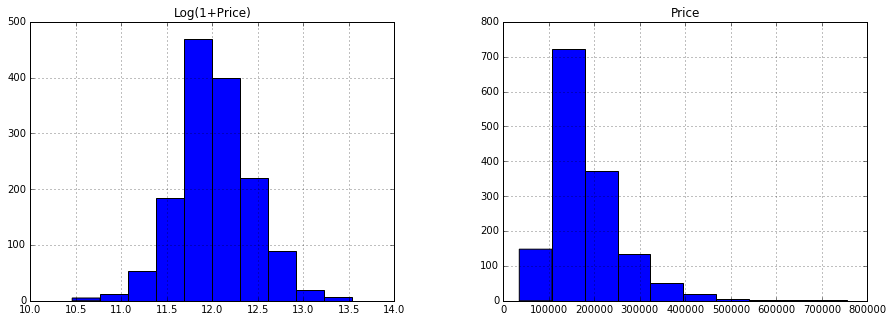

In [29]:
pr_for_hist = pd.DataFrame({"Price": DF.loc[trn, "SalePrice"], "Log(1+Price)": np.log1p(DF.loc[trn, "SalePrice"])})
pr_for_hist.hist()

In [30]:
num_feats = DF.columns[DF.dtypes != object]
skewed_feats = [x for x in num_feats if skew(DF.loc[:,x].dropna())>.75]
DF[skewed_feats] = np.log1p(DF[skewed_feats])

## Scaling: mean-centering and variance scaling

In [53]:
# Scale the features
scaler_feats = preprocessing.StandardScaler()
scaler_feats.fit(DF.loc[trn,:].drop(["SalePrice"],axis=1))
X_trn = scaler_feats.transform(DF.loc[trn,:].drop(["SalePrice"],axis=1))
X_tst = scaler_feats.transform(DF.loc[tst,:].drop(["SalePrice"],axis=1))

# Scale the target
scaler_price = preprocessing.StandardScaler()
scaler_price.fit(DF.loc[trn,"SalePrice"].reshape(-1,1))
y_trn = scaler_price.transform(DF.loc[trn,"SalePrice"].reshape(-1, 1))

In [56]:
y_trn = [x[0] for x in y_trn]

# Prediction
Prep dataframe for prediction.

In [33]:
#X_trn = DF.loc[ trn, DF.columns.difference(["SalePrice"]) ]
#X_tst = DF.loc[ tst, DF.columns.difference(["SalePrice"]) ]
#y = DF.loc[trn,"SalePrice"].copy()

## Ridge regression with CV for alpha selection

In [57]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_trn, y_trn, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

0.31729849739437155

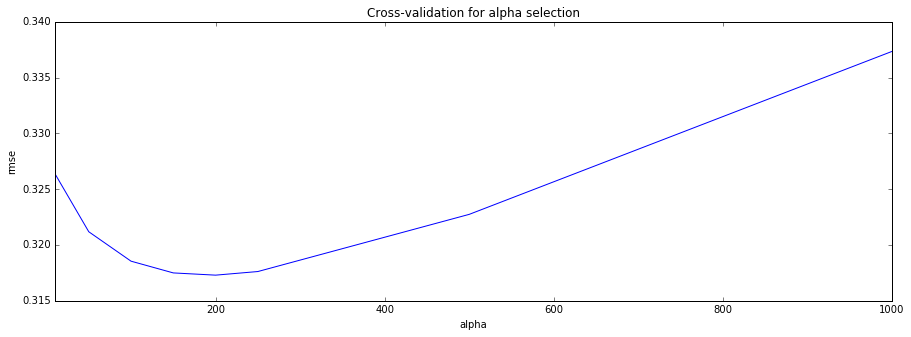

In [58]:

alphas = [10, 50, 100, 150, 200, 250, 500, 1000]
cv_ridge = [rmse_cv(linear_model.Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Cross-validation for alpha selection")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

In [59]:
model_ridge = linear_model.Ridge(alpha = 200)
model_ridge.fit(X_trn, y_trn)
pred_raw = model_ridge.predict(X_tst)
pred_scaled = scaler_price.inverse_transform(pred_raw)
pred = np.expm1(pred_scaled) 

In [60]:
# CV score
scores = cross_val_score(model_ridge, X_trn, y_trn, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.04)


print(pred.shape)
print(np.arange(n_trn+1,n_ttl+1).reshape(-1,1).shape)
#np.vstack((np.arange(n_trn+1,n_ttl+1), pred))

In [61]:
pred2 = np.expm1(model_ridge.predict(X_tst))
type(pred)

numpy.ndarray

In [62]:


# Prepare submission
subm_ndar = np.vstack((np.arange(n_trn+1,n_ttl+1), pred)).T
submission_df = pd.DataFrame(subm_ndar, columns = ['Id', 'SalePrice'], dtype=int)
# Write to file
submission_df.to_csv("subm_RRCV.csv", index=False)

## Lasso with CV for alpha selection

In [63]:
y_trn.reshape(-1,1)

AttributeError: 'list' object has no attribute 'reshape'

In [73]:

# LASSO
model_lasso = linear_model.LassoCV(alphas = [0.0005, 0.001, 0.002, 0.005, 0.01]).fit(X_trn, y_trn)

#pred = np.expm1(model_lasso.predict(X_tst))

pred_raw = model_lasso.predict(X_tst)
pred_scaled = scaler_price.inverse_transform(pred_raw)
pred = np.expm1(pred_scaled)
pred[2]
# Scale the pred

# Prepare submission
subm_ndar = np.vstack((np.arange(n_trn+1,n_ttl+1), pred)).T
submission_df = pd.DataFrame(subm_ndar, columns = ['Id', 'SalePrice'], dtype=int)

# Write to file
submission_df.to_csv("subm_Lasso.csv", index=False)
rmse_cv(model_lasso).mean()

0.30836926691121702

In [74]:
# CV score
scores = cross_val_score(model_lasso, X_trn, y_trn, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.05)
